#TP2 Aprendizaje Automático II


# Problema 1

# Instalación de dependencias y configuración del entorno

In [ ]:
!pip install -q tensorflow tensorflow-datasets librosa

import os
import pathlib
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga del dataset

In [ ]:
# Carga el dataset spoken_digit
ds, ds_info = tfds.load('spoken_digit', split='train', with_info=True, as_supervised=True)

# Variables útiles
num_examples = ds_info.splits['train'].num_examples
label_names = ds_info.features['label'].names

print(f"Dataset cargado: {ds_info.name}")
print(f"Número total de ejemplos: {num_examples}")
print(f"Etiquetas disponibles: {label_names}")

Dataset cargado: spoken_digit
Número total de ejemplos: 2500
Etiquetas disponibles: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Los clips de audio del conjunto de datos se almacenan en diez carpetas correspondientes a cada dígito

In [ ]:
# Obtener las etiquetas (comandos) directamente desde los metadatos del dataset
commands = np.array(ds_info.features['label'].names)
print('Commands:', commands)

Commands: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [ ]:
# Convertir dataset completo a lista para dividirlo
ds = ds.shuffle(2500, seed=0)

# Definir fracción de validación
val_split = 0.2
val_size = int(2500 * val_split)
train_size = 2500 - val_size

# Separar en entrenamiento y validación
train_ds = ds.take(train_size).batch(64)
val_ds = ds.skip(train_size).batch(64)

# Obtener nombres de etiquetas
label_names = np.array(ds_info.features['label'].names)

print("label names:", label_names)

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Extracción y preprocesamiento de datos

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Observamos que cada elemento del dataset es una tupla con dos tensores:

Primer tensor: shape=(None, None). Es una matriz de tamaño variable en ambas dimensiones.

Segundo tensor: shape=(None,). Es un vector de tamaño variable.

Normalizamos la longitud de cada señal de audio a un tamaño fijo.

In [ ]:
DESIRED_LENGTH = 6000

def pad_or_trim(audio, label):
  audio = tf.cast(audio, tf.float32)
  audio = audio[:DESIRED_LENGTH]
  zero_padding = tf.zeros([DESIRED_LENGTH] - tf.shape(audio), dtype=tf.float32)
  audio = tf.concat([audio, zero_padding], 0)
  return audio, label


ds = ds.shuffle(2500, seed=0) # Mezcla aleatoriamente los datos, útil para evitar sesgo en el entrenamiento.
ds = ds.map(pad_or_trim, num_parallel_calls=tf.data.AUTOTUNE) # Aplica la función de padding/recorte a cada muestra.

train_ds = ds.take(2000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = ds.skip(2000).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6000)
(64,)


El primer tensor (example_audio) es un batch de 64 ejemplos, cada uno con 6000 muestras (audios ya normalizados en longitud y tipo).

El segundo tensor (example_labels) es un vector de 64 etiquetas, una por cada audio en el batch.



# Visualización

Mostramos la forma de onda de un archivo de audio individual, después de ser procesado y normalizado a 6000 muestras.

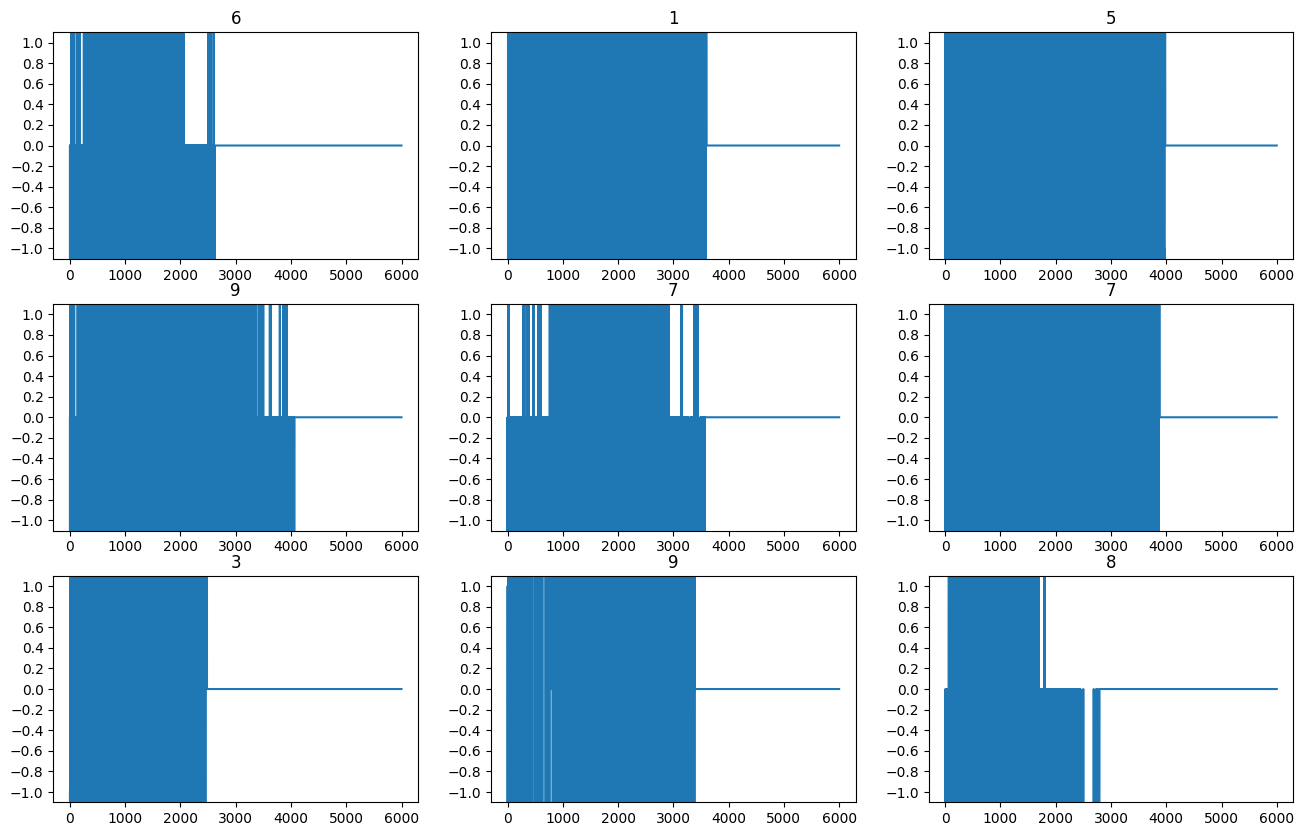

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

La porción activa de cada onda se concentra en los primeros 2,000 a 4,500 samples; el resto es padding en cero. En otras palabras, solo una parte de la señal contiene información útil (zona azul); el resto es una línea plana en 0.

Esto confirma que los audios originales son más cortos que 6000 muestras, y que la mayor parte de cada señal está “rellenada” con ceros (silencio) al final, debido a la función pad_or_trim.

Observamos que todos los audios tienen la misma longitud, y los audios cortos se completan correctamente con ceros.

La visualización confirma que la mayoría de las muestras de audio son mucho más cortas que el tamaño objetivo y que el padding no introduce valores fuera del rango [-1, 1].

# Convertir formas de onda a espectrogramas

In [ ]:
def get_spectrogram(waveform):
  # Convierte la onda en un espectrograma mediante una STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  # Obtiene la magnitud de la STFT.
  spectrogram = tf.abs(spectrogram)

  # Agrega una dimensión de `canales`, para que el espectrograma pueda usarse
  # como entrada similar a una imagen en capas convolucionales (las cuales esperan
  # forma (`batch_size`, `altura`, `ancho`, `canales`)).
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

Imprimimos las formas de uno de los ejemplos y reproducimos el audio original.

In [ ]:
for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: 6
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 1
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 5
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 9
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Label: 7
Waveform shape: (6000,)
Spectrogram shape: (45, 129, 1)
Audio playback


Confirmamos que:

Todas las ondas de audio están correctamente normalizadas a 6000 muestras.

La conversión a espectrograma genera tensores de forma consistente para todos los ejemplos).

Las etiquetas y los datos de audio están correctamente alineados.

Es posible reproducir los audios para auditoría manual.



Definimos una función para mostrar el espectrograma

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convertir las frecuencias a escala logarítmica y transponer, de modo que el tiempo
  # se represente en el eje x (columnas).
  # Se añade un épsilon para evitar tomar el logaritmo de cero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Graficamos formas de onda y sus espectrogramas

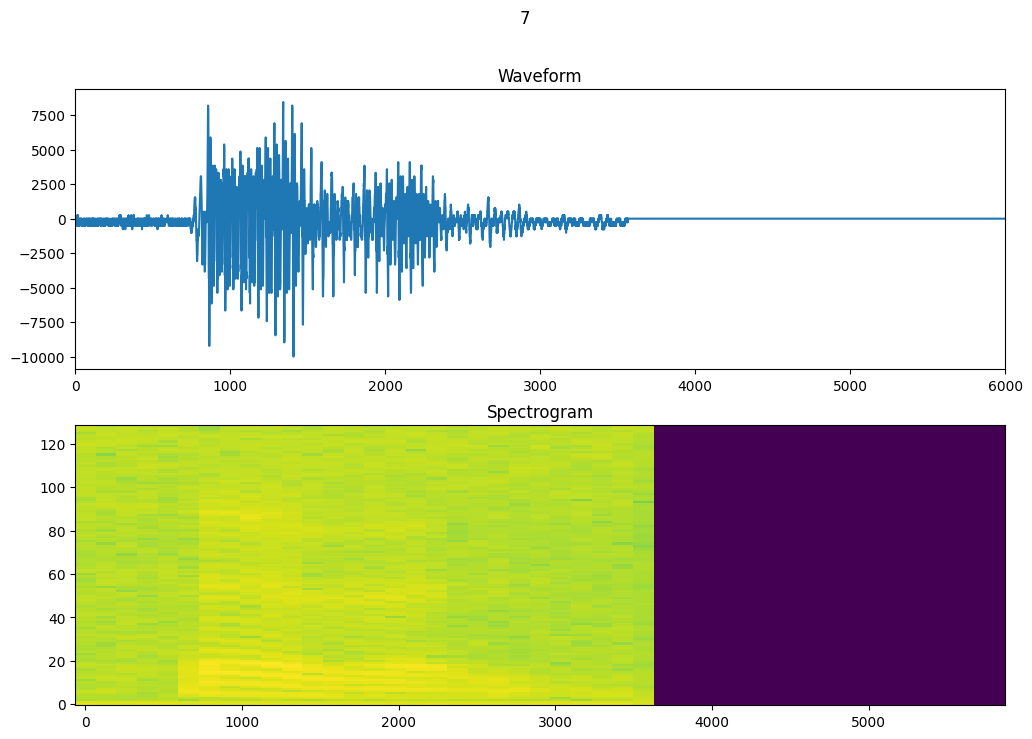

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 6000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Forma de onda (Waveform): No hay cortes abruptos, todo el contenido útil de la señal está incluido y el padding se visualiza claramente como línea plana.

Espectrograma: La actividad (colores) sólo aparece en la porción izquierda del espectrograma (hasta ~3,000). El resto es completamente negro/violeta, reflejando el padding.


Ahora creamos un dataset de espectrogramas utilizando la función definida

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Examinar el espectrograma para distintos ejemplos del dataset

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

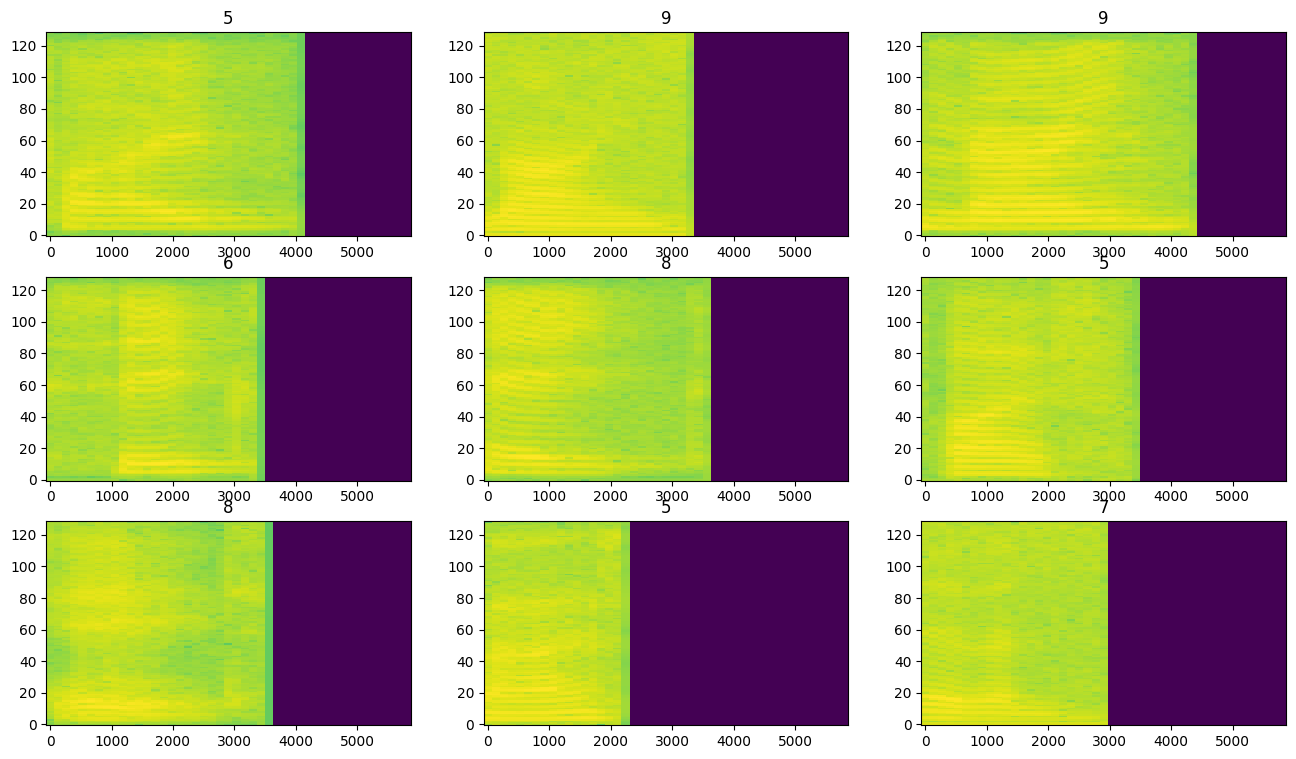

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Observamos que el padding es consistente y ocupa menos de la mitad del espectrograma, mostrando que la longitud elegida es eficiente: no hay exceso de ceros, pero tampoco recorte de la señal útil. Las diferencias entre espectrogramas permiten al modelo distinguir entre las diferentes etiquetas.

Se distinguen varias clases diferentes en el batch, lo que permite verificar visualmente que el pipeline de preprocesamiento está aplicando correctamente las transformaciones y alineando datos con sus etiquetas.

# Modelo CNN

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instanciar la capa `tf.keras.layers.Normalization`.
norm_layer = layers.Normalization()
# Ajustar el estado de la capa a los espectrogramas
# usando `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Reducir la resolución de entrada.
    layers.Resizing(32, 32),
    # Normalizar.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

Input shape: (45, 129, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Entrenamiento

Entrenamos durante 50 epochs con early stopping  (para evitar overfitting)

In [ ]:
EPOCHS = 50
cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.2940 - loss: 2.0145 - val_accuracy: 0.6480 - val_loss: 1.2388
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5702 - loss: 1.2706 - val_accuracy: 0.8160 - val_loss: 0.8086
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7125 - loss: 0.8911 - val_accuracy: 0.8540 - val_loss: 0.5436
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7891 - loss: 0.6879 - val_accuracy: 0.9000 - val_loss: 0.4198
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8334 - loss: 0.5136 - val_accuracy: 0.9480 - val_loss: 0.2610
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8741 - loss: 0.4221 - val_accuracy: 0.9500 - val_loss: 0.1919
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8874 - loss: 0.3607 - val_accuracy: 0.9560 - val_loss: 0.1534
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9180 - loss: 0.2452 - val_accuracy: 0.9680 - va

## Visualización

Text(0, 0.5, 'Accuracy [%]')

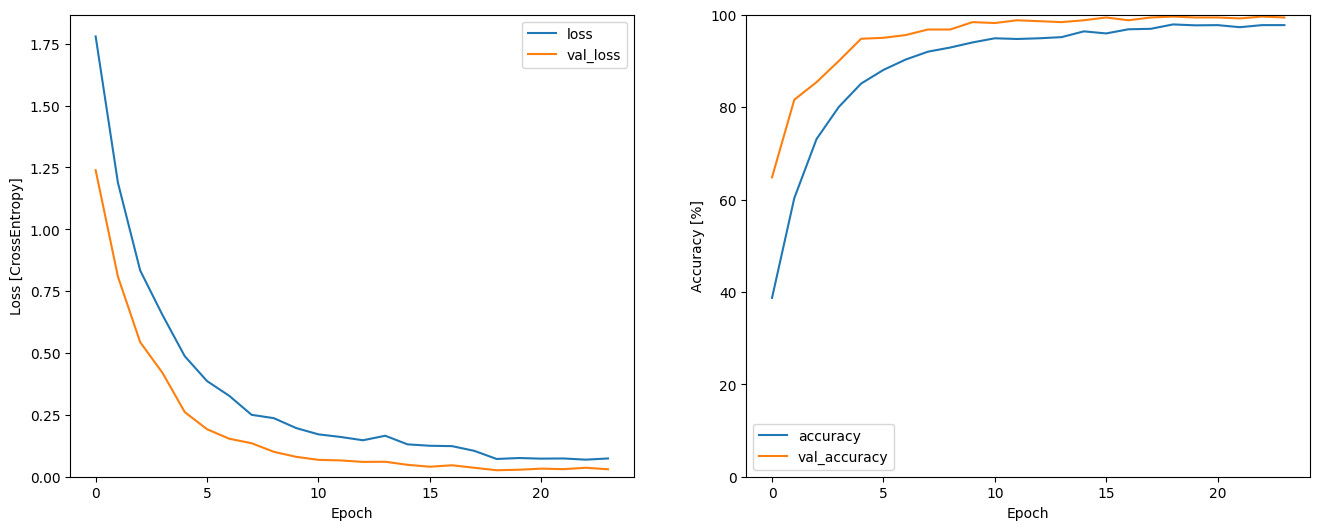

In [ ]:
metrics = cnn_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(cnn_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(cnn_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

No hay señales de sobreajuste:

La validación nunca se despega ni se degrada respecto al entrenamiento.

La precisión y la pérdida son incluso mejores en validación, lo cual es poco frecuente pero puede darse si el set de validación es ligeramente más fácil o más balanceado que el de entrenamiento.

El modelo aprendió muy rápido y eficientemente:

Converge a excelente desempeño en pocas épocas.

La elección de arquitectura y preprocesamiento está bien alineada con el problema.

## Métricas

In [ ]:
y_pred_cnn = cnn_model.predict(val_spectrogram_ds)
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)
y_true_cnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
print(classification_report(y_true_cnn, y_pred_cnn, target_names=[str(l) for l in label_names]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        50
           2       0.98      1.00      0.99        52
           3       1.00      0.98      0.99        56
           4       1.00      1.00      1.00        54
           5       0.98      1.00      0.99        43
           6       0.98      1.00      0.99        46
           7       1.00      0.98      0.99        57
           8       1.00      1.00      1.00        47
           9       1.00      0.98      0.99        50

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



El modelo muestra un desempeño excelente en todas las clases.

No hay ninguna clase que quede claramente relegada o ignorada.

No existe sobreajuste evidente hacia una sola clase.

El rendimiento es consistente y muy alto tanto por clase como en promedio.

# Modelo RNN

In [ ]:
input_shape = (54, 129, 1)   # Sin el batch size
num_labels = 10

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))

rnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    layers.Reshape((64, 64)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

rnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,821 (905.55 KB)

 Trainable params: 231,818 (905.54 KB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo

In [ ]:
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Entrenamiento

In [ ]:
rnn_history = rnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2440 - loss: 2.1244 - val_accuracy: 0.6040 - val_loss: 1.2745
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5851 - loss: 1.1865 - val_accuracy: 0.8180 - val_loss: 0.5790
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7742 - loss: 0.6441 - val_accuracy: 0.8620 - val_loss: 0.3898
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8761 - loss: 0.3918 - val_accuracy: 0.9620 - val_loss: 0.1915
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9190 - loss: 0.2518 - val_accuracy: 0.9360 - val_loss: 0.1814
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9039 - loss: 0.2955 - val_accuracy: 0.9720 - val_loss: 0.1384
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9525 - loss: 0.1838 - val_accuracy: 0.9740 - val_loss: 0.1023
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9525 - loss: 0.1568 - val_accuracy: 0.9660 - v

## Visualización

Text(0, 0.5, 'Accuracy [%]')

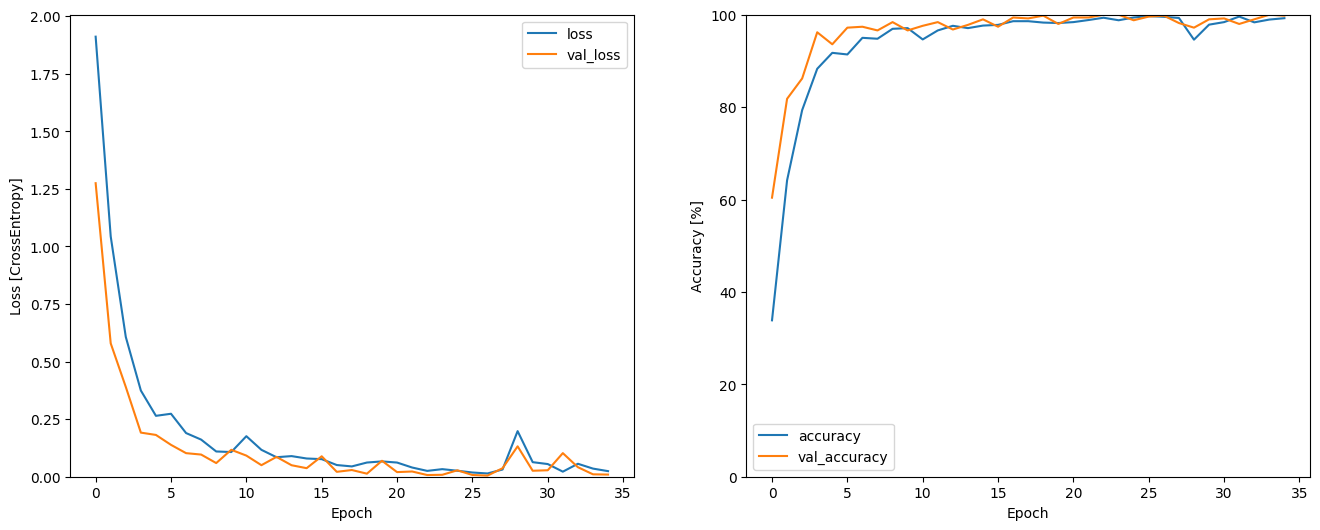

In [ ]:
metrics = rnn_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(rnn_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(rnn_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

En la función de pérdida, hay pequeñas oscilaciones o “picos” en algunas épocas, tanto en entrenamiento como en validación. Esto puede deberse a batches atípicos, alta tasa de aprendizaje, o ruido en los datos.

El modelo generaliza bien: No hay indicios de sobreajuste ni subajuste. Las oscilaciones son menores y no afectan a la precisión final.

Las curvas de precisión son altas, lo que ratifica que la arquitectura y el preprocesamiento están funcionando correctamente.



## Métricas

In [ ]:
y_pred_rnn = rnn_model.predict(val_spectrogram_ds)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
print(classification_report(y_true_rnn, y_pred_rnn, target_names=[str(l) for l in label_names]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        56
           4       1.00      0.98      0.99        54
           5       1.00      1.00      1.00        43
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        57
           8       1.00      1.00      1.00        47
           9       1.00      1.00      1.00        50

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



El modelo es muy robusto y preciso, con excelente desempeño en todas las clases.

No hay ninguna clase con desempeño bajo.

Rendimiento global del modelo: sobresaliente.

# Evaluación y comparación de modelos

## Precisión

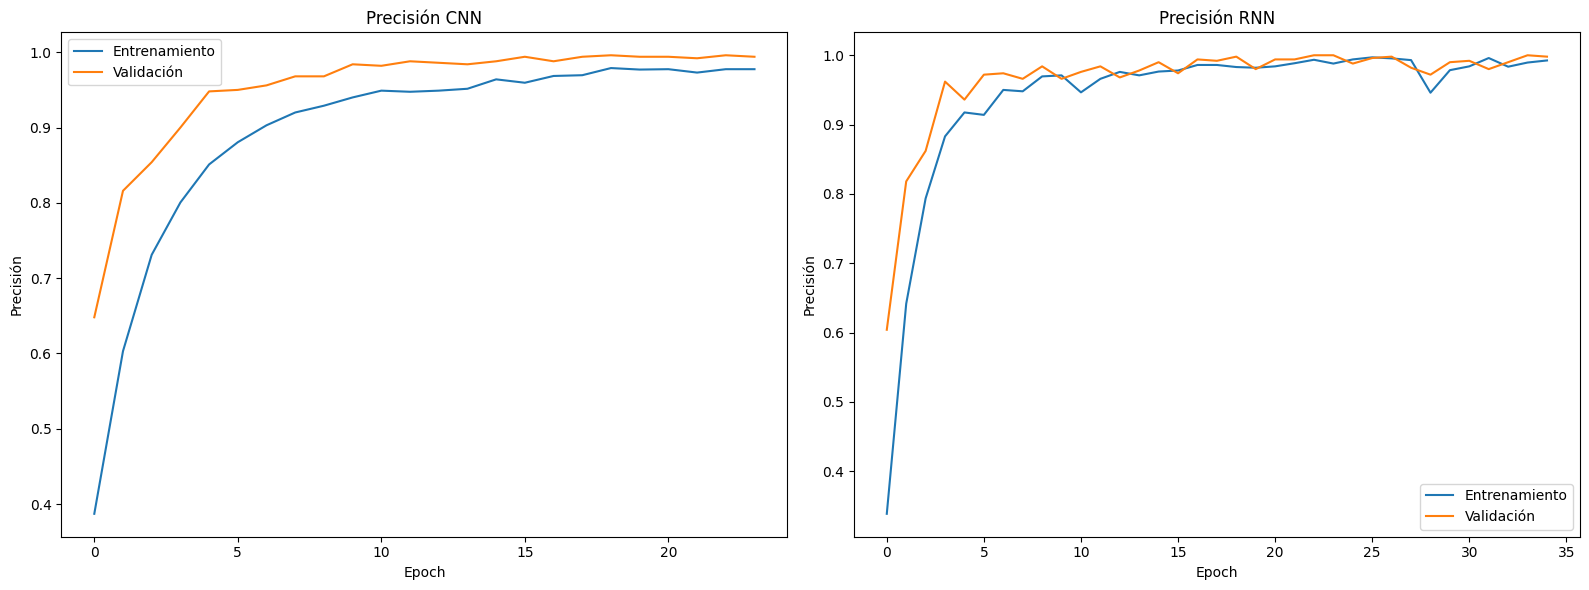

In [ ]:
def plot_history_subplot(history, title, ax):
    ax.plot(history.history['accuracy'], label='Entrenamiento')
    ax.plot(history.history['val_accuracy'], label='Validación')
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Precisión")
    ax.legend()

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_history_subplot(cnn_history, "Precisión CNN", axes[0])
plot_history_subplot(rnn_history, "Precisión RNN", axes[1])

plt.tight_layout()
plt.show()

La RNN se observa con más oscilaciones, quizás explicado por la sensibilidad al orden y contexto de la naturaleza secuencial. La CNN es más estable en ese sentido.

Las curvas de validación se estabilizan temprano, alrededor de la época 10 en ambos casos, llegando a valores altos y constantes.

Ambos modelos (CNN y RNN) muestran una curva de aprendizaje muy buena, alcanzando una precisión de validación cercana a 1.0 en pocas épocas y manteniéndose alta y estable.

El desempeño en entrenamiento y validación es alto y muy parejo en ambos modelos, lo cual indica: No hay overfitting significativo. El modelo generaliza bien y la validación no cae respecto al entrenamiento.





## Matrices de confusión

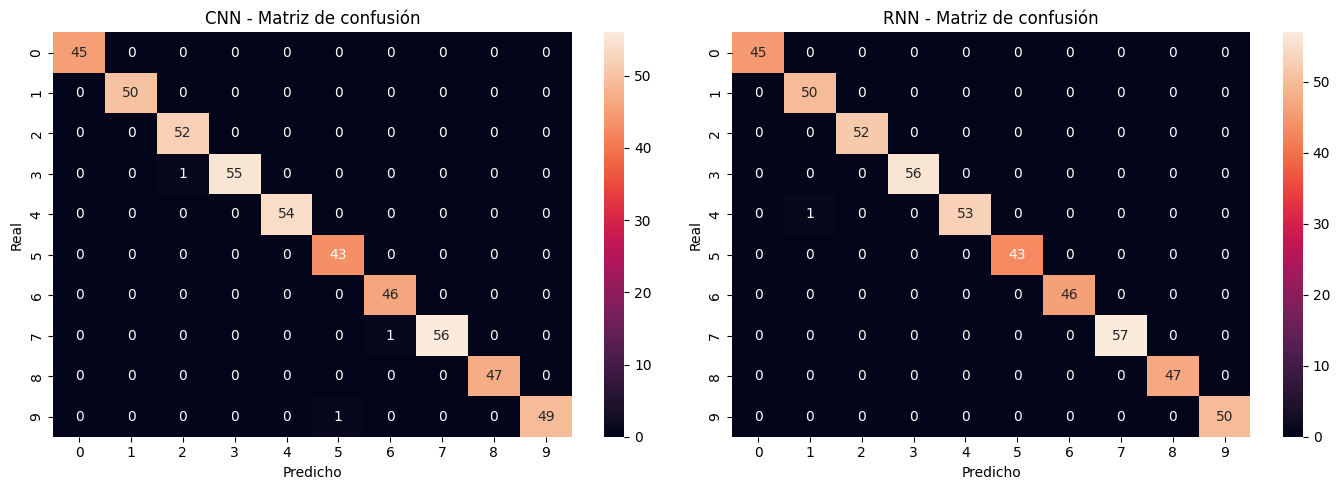

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

# Asegura los nombres de las etiquetas
try:
    label_names
except NameError:
    label_names = [str(i) for i in range(np.max(y_true_cnn)+1)]

# Graficar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_confusion_matrix(y_true_cnn, y_pred_cnn, label_names, "CNN - Matriz de confusión", axes[0])
plot_confusion_matrix(y_true_rnn, y_pred_rnn, label_names, "RNN - Matriz de confusión", axes[1])

plt.tight_layout()
plt.show()

El modelo CNN comete dos errores más que el RNN, sin ser una diferencia significativa.

En ambas matrices no hay clases que concentren muchos errores. Ambos modelos tienen un excelente desempeño.



# Conclusiones

## Desempeño Predictivo

Ambos modelos muestran un desempeño general alto en la tarea de clasificación de señales de audio, alcanzando precisiones globales del 100% sobre el conjunto de validación.

La matriz de confusión no muestra una diferencia significativa entre los errores de ambos modelos, que son prácticamente irrelevantes.

Ambos modelos generalizan muy bien y no presentan problemas de sobreajuste.

## Tamaño y eficiencia

El modelo RNN es considerablemente más pequeño: ~232 mil parámetros (0.9 MB) frente a ~1.6 millones de parámetros (6.2 MB) en la CNN.

Esto implica que la RNN requiere menos memoria, es más fácil de desplegar en dispositivos con recursos limitados, puede ser más rápida en inferencia, especialmente donde el tamaño del modelo sea crítico.


## Conclusión final

Consideramos que ambos modelos son una muy buena opción para este problema, pero teniendo en cuenta que no hay diferencias significativas en el desempeño, y que el RNN es significativamente más pequeño, nos decantamos por este último.